In [33]:
import h5py

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

import pandas as pd
import seaborn as sns



In [109]:
ECHO = "Echo 1"
dataframe_1_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-34/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_1_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-37/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_1_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-40/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_1_1['version'] = '1'
dataframe_1_1['echo'] = '1'
dataframe_1_2['version'] = '2'
dataframe_1_2['echo'] = '1'
dataframe_1_3['version'] = '3'
dataframe_1_3['echo'] = '1'

dataframe_1 = pd.concat([dataframe_1_1,dataframe_1_2,dataframe_1_3])

ECHO = "Echo 2"
dataframe_2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-34/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-37/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-40/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_2_1['version'] = '1'
dataframe_2_1['echo'] = '2'
dataframe_2_2['version'] = '2'
dataframe_2_2['echo'] = '2'
dataframe_2_3['version'] = '3'
dataframe_2_3['echo'] = '2'

dataframe_2 = pd.concat([dataframe_2_1,dataframe_2_2,dataframe_2_3])

dataframe_seg_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-34/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-37/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-40/predictions/results_segmentation.xlsx",index_col=0)
print(dataframe_seg_2.head)
dataframe_seg_1['version'] = '1'
dataframe_seg_2['version'] = '2'
dataframe_seg_3['version'] = '3'
dataframe_seg = pd.concat([dataframe_seg_1,dataframe_seg_2,dataframe_seg_3])


dataframe_t2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-34/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
dataframe_t2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-37/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
dataframe_t2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_NO_MTL_def/2024-05-23_12-22-40/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)

dataframe_t2_1['version'] = '1'
dataframe_t2_2['version'] = '2'
dataframe_t2_3['version'] = '3'
dataframe_t2 = pd.concat([dataframe_t2_1,dataframe_t2_2,dataframe_t2_3])

dataframe_NO_MTL = pd.concat([dataframe_1,dataframe_2,dataframe_seg,dataframe_t2])

ECHO = "Echo 1"
dataframe_1_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-07/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_1_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-10/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_1_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-13/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_1_1['version'] = '1'
dataframe_1_1['echo'] = '1'
dataframe_1_2['version'] = '2'
dataframe_1_2['echo'] = '1'
dataframe_1_3['version'] = '3'
dataframe_1_3['echo'] = '1'
dataframe_1 = pd.concat([dataframe_1_1,dataframe_1_2,dataframe_1_3])
ECHO = "Echo 2"
dataframe_2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-07/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-10/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-13/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_2_1['version'] = '1'
dataframe_2_1['echo'] = '2'
dataframe_2_2['version'] = '2'
dataframe_2_2['echo'] = '2'
dataframe_2_3['version'] = '3'
dataframe_2_3['echo'] = '2'
dataframe_2 = pd.concat([dataframe_2_1,dataframe_2_2,dataframe_2_3])

dataframe_seg_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-07/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-10/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-13/predictions/results_segmentation.xlsx",index_col=0)

dataframe_seg_1['version'] = '1'
dataframe_seg_2['version'] = '2'
dataframe_seg_3['version'] = '3'
dataframe_seg = pd.concat([dataframe_seg_1,dataframe_seg_2,dataframe_seg_3])

dataframe_t2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-07/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
dataframe_t2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-10/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
dataframe_t2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-13/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)

dataframe_t2_1['version'] = '1'
dataframe_t2_2['version'] = '2'
dataframe_t2_3['version'] = '3'
dataframe_t2 = pd.concat([dataframe_t2_1,dataframe_t2_2,dataframe_t2_3])

dataframe_SUM_LOGIT = pd.concat([dataframe_1,dataframe_2,dataframe_seg,dataframe_t2])

ECHO = "Echo 1"
dataframe_1_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_SOFTMAX_SASG_test/2024-05-24_12-05-53/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
# dataframe_1_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-10/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
# dataframe_1_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-13/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_1_1['version'] = '1'
dataframe_1_1['echo'] = '1'
# dataframe_1_2['version'] = '2'
# dataframe_1_2['echo'] = '1'
# dataframe_1_3['version'] = '3'
# dataframe_1_3['echo'] = '1'
dataframe_1 = pd.concat([dataframe_1_1])
ECHO = "Echo 2"
dataframe_2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_SOFTMAX_SASG_test/2024-05-24_12-05-53/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
# dataframe_2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-10/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
# dataframe_2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-13/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_2_1['version'] = '1'
dataframe_2_1['echo'] = '2'
# dataframe_2_2['version'] = '2'
# dataframe_2_2['echo'] = '2'
# dataframe_2_3['version'] = '3'
# dataframe_2_3['echo'] = '2'
dataframe_2 = pd.concat([dataframe_2_1])

dataframe_seg_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_SOFTMAX_SASG_test/2024-05-24_12-05-53/predictions/results_segmentation.xlsx",index_col=0)
# dataframe_seg_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-10/predictions/results_segmentation.xlsx",index_col=0)
# dataframe_seg_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-13/predictions/results_segmentation.xlsx",index_col=0)

dataframe_seg_1['version'] =' 1'
# dataframe_seg_2['version'] = '2'
#dataframe_seg_3['version'] = '3'
dataframe_seg = pd.concat([dataframe_seg_1])

dataframe_t2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_SOFTMAX_SASG_test/2024-05-24_12-05-53/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
# dataframe_t2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-10/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
# dataframe_t2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-13/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)

dataframe_t2_1['version'] = '1'
# dataframe_t2_2['version'] = '2'
# dataframe_t2_3['version'] = '3'
dataframe_t2 = pd.concat([dataframe_t2_1])
dataframe_SASG_SOFTMAX = pd.concat([dataframe_1,dataframe_2,dataframe_seg,dataframe_t2])
ECHO = "Echo 1"
dataframe_1_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-28_20-53-08/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_1_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-28_20-53-11/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_1_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-29_11-48-43/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_1_1['version'] = '1'
dataframe_1_1['echo'] = '1'
dataframe_1_2['version'] = '2'
dataframe_1_2['echo'] = '1'
dataframe_1_3['version'] = '3'
dataframe_1_3['echo'] = '1'
dataframe_1 = pd.concat([dataframe_1_1,dataframe_1_2,dataframe_1_3])
ECHO = "Echo 2"
dataframe_2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-28_20-53-08/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-28_20-53-11/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-13/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_2_1['version'] = '1'
dataframe_2_1['echo'] = '2'
dataframe_2_2['version'] = '2'
dataframe_2_2['echo'] = '2'
dataframe_2_3['version'] = '3'
dataframe_2_3['echo'] = '2'
dataframe_2 = pd.concat([dataframe_2_1,dataframe_2_2,dataframe_2_3])

dataframe_seg_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-28_20-53-08/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-28_20-53-11/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-29_11-48-43/predictions/results_segmentation.xlsx",index_col=0)

dataframe_seg_1['version'] =' 1'
dataframe_seg_2['version'] = '2'
dataframe_seg_3['version'] = '3'
dataframe_seg = pd.concat([dataframe_seg_1,dataframe_seg_2,dataframe_seg_3])

dataframe_t2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-28_20-53-08/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
dataframe_t2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-28_20-53-11/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
dataframe_t2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SASG_def/2024-05-29_11-48-43/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)

dataframe_t2_1['version'] = '1'
dataframe_t2_2['version'] = '2'
dataframe_t2_3['version'] = '3'
dataframe_t2 = pd.concat([dataframe_t2_1,dataframe_t2_2,dataframe_t2_3])
dataframe_SASG_SOFTMAX_AP = pd.concat([dataframe_1,dataframe_2,dataframe_seg,dataframe_t2])


ECHO = "Echo 1"
dataframe_1_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-29_15-20-28/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_1_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-29_15-20-31/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_1_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-31_08-40-15/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_1_1['version'] = '1'
dataframe_1_1['echo'] = '1'
dataframe_1_2['version'] = '2'
dataframe_1_2['echo'] = '1'
dataframe_1_3['version'] = '3'
dataframe_1_3['echo'] = '1'
dataframe_1 = pd.concat([dataframe_1_1,dataframe_1_2,dataframe_1_3])
ECHO = "Echo 2"
dataframe_2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-29_15-20-28/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-29_15-20-31/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-31_08-40-15/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_2_1['version'] = '1'
dataframe_2_1['echo'] = '2'
dataframe_2_2['version'] = '2'
dataframe_2_2['echo'] = '2'
dataframe_2_3['version'] = '3'
dataframe_2_3['echo'] = '2'
dataframe_2 = pd.concat([dataframe_2_1,dataframe_2_2])

dataframe_seg_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-29_15-20-28/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-29_15-20-31/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-31_08-40-15/predictions/results_segmentation.xlsx",index_col=0)

dataframe_seg_1['version'] =' 1'
dataframe_seg_2['version'] = '2'
dataframe_seg_3['version'] = '3'
dataframe_seg = pd.concat([dataframe_seg_1,dataframe_seg_2,dataframe_seg_3])

dataframe_t2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-29_15-20-28/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
dataframe_t2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-29_15-20-31/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
dataframe_t2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_TAM_def/2024-05-31_08-40-15/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)

dataframe_t2_1['version'] = '1'
dataframe_t2_2['version'] = '2'
dataframe_t2_3['version'] = '3'
dataframe_t2 = pd.concat([dataframe_t2_1,dataframe_t2_2,dataframe_t2_3])
dataframe_SOFTMAX_TAM = pd.concat([dataframe_1,dataframe_2,dataframe_seg,dataframe_t2])

ECHO = "Echo 1"
dataframe_1_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-29_11-49-51/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_1_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-30_10-14-41/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_1_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-30_10-14-44/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_1_1['version'] = '1'
dataframe_1_1['echo'] = '1'
dataframe_1_2['version'] = '2'
dataframe_1_2['echo'] = '1'
dataframe_1_3['version'] = '3'
dataframe_1_3['echo'] = '1'
dataframe_1 = pd.concat([dataframe_1_1,dataframe_1_2,dataframe_1_3])
ECHO = "Echo 2"
dataframe_2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-29_11-49-51/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-30_10-14-41/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-30_10-14-44/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_2_1['version'] = '1'
dataframe_2_1['echo'] = '2'
dataframe_2_2['version'] = '2'
dataframe_2_2['echo'] = '2'
dataframe_2_3['version'] = '3'
dataframe_2_3['echo'] = '2'
dataframe_2 = pd.concat([dataframe_2_1,dataframe_2_2
                         ,dataframe_2_3])

dataframe_seg_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-29_11-49-51/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-10/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SENSE_LOGIT_SUM_def/2024-05-23_12-28-13/predictions/results_segmentation.xlsx",index_col=0)

dataframe_seg_1['version'] =' 1'
dataframe_seg_2['version'] = '2'
dataframe_seg_3['version'] = '3'
dataframe_seg = pd.concat([dataframe_seg_1,dataframe_seg_2,dataframe_seg_3])

dataframe_t2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-29_11-49-51/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
dataframe_t2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-30_10-14-41/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
dataframe_t2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_SOFTMAX_SUM_def/2024-05-30_10-14-44/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)

dataframe_t2_1['version'] = '1'
dataframe_t2_2['version'] = '2'
dataframe_t2_3['version'] = '3'
dataframe_t2 = pd.concat([dataframe_t2_1,dataframe_t2_2,dataframe_t2_3])
dataframe_SUM_SOFTMAX = pd.concat([dataframe_1,dataframe_2,dataframe_seg,dataframe_t2])

ECHO = "Echo 1"
dataframe_1_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-02/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_1_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-05/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_1_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-08/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_1_1['version'] = '1'
dataframe_1_1['echo'] = '1'
dataframe_1_2['version'] = '2'
dataframe_1_2['echo'] = '1'
dataframe_1_3['version'] = '3'
dataframe_1_3['echo'] = '1'
dataframe_1 = pd.concat([dataframe_1_1,dataframe_1_2,dataframe_1_3])
ECHO = "Echo 2"
dataframe_2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-02/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-05/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)
dataframe_2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-08/predictions/results_reconstruction.xlsx",sheet_name=ECHO,index_col=0)

dataframe_2_1['version'] = '1'
dataframe_2_1['echo'] = '2'
dataframe_2_2['version'] = '2'
dataframe_2_2['echo'] = '2'
dataframe_2_3['version'] = '3'
dataframe_2_3['echo'] = '2'
dataframe_2 = pd.concat([dataframe_2_1,dataframe_2_2
                         ,dataframe_2_3])

dataframe_seg_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-02/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-05/predictions/results_segmentation.xlsx",index_col=0)
dataframe_seg_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-08/predictions/results_segmentation.xlsx",index_col=0)

dataframe_seg_1['version'] =' 1'
dataframe_seg_2['version'] = '2'
dataframe_seg_3['version'] = '3'
dataframe_seg = pd.concat([dataframe_seg_1,dataframe_seg_2,dataframe_seg_3])

dataframe_t2_1 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-02/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
dataframe_t2_2 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-05/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)
dataframe_t2_3 = pd.read_excel("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/MTLRS_SKMTEA_LOGIT_TAM_def/2024-05-31_08-42-08/predictions/results_T2_quantification.xlsx",sheet_name="Multitask Abs T2 Error",index_col=0)

dataframe_t2_1['version'] = '1'
dataframe_t2_2['version'] = '2'
dataframe_t2_3['version'] = '3'
dataframe_t2 = pd.concat([dataframe_t2_1,dataframe_t2_2,dataframe_t2_3])
dataframe_LOGIT_TAM = pd.concat([dataframe_1,dataframe_2,dataframe_seg,dataframe_t2])

dataframe_SUM_LOGIT['type'] = "SUM LOGIT AP"
dataframe_NO_MTL['type'] = "NO MTL AP"
#dataframe_SASG_SOFTMAX['type'] = "SASG"
dataframe_SASG_SOFTMAX_AP['type'] = "SASG AP"
dataframe_SOFTMAX_TAM['type'] = "TAM SOFTMAX AP"
dataframe_SUM_SOFTMAX['type'] = "SUM SOFTMAX AP"
dataframe_LOGIT_TAM['type'] = "TAM LOGIT AP"

dataframe = pd.concat([dataframe_NO_MTL,dataframe_SUM_LOGIT,dataframe_SASG_SOFTMAX_AP,dataframe_SOFTMAX_TAM,dataframe_SUM_SOFTMAX,dataframe_LOGIT_TAM])




<bound method NDFrame.head of          id      DICE        F1      HD95       IOU       ASD
0   MTR_005  0.853602  0.487943  6.225703  0.603354  0.098581
1   MTR_006  0.827981  0.452957  4.635937  0.538638  0.113087
2   MTR_030  0.730678  0.407425  7.419230  0.373007  0.188274
3   MTR_034  0.843434  0.514808  5.874897  0.531825  0.123469
4   MTR_048  0.868091  0.575288  6.164972  0.615642  0.084411
5   MTR_052  0.607349  0.376085  6.265945  0.279106  0.272468
6   MTR_065  0.832371  0.540092  6.474943  0.522370  0.140118
7   MTR_066  0.766589  0.403123  5.780839  0.356997  0.331781
8   MTR_079  0.800157  0.460780  4.764226  0.475282  0.126582
9   MTR_080  0.856009  0.532366  5.813622  0.554779  0.110288
10  MTR_096  0.870947  0.577970  5.720355  0.639934  0.087145
11  MTR_099  0.842745  0.524081  6.698651  0.535279  0.135423
12  MTR_120  0.813006  0.474057  7.315403  0.434715  0.264185
13  MTR_126  0.836938  0.497825  6.784221  0.488980  0.144579
14  MTR_144  0.785728  0.541713  6.44102

[atommic W 2024-06-02 17:08:39 atommic_logging:336] /scratch/tmpaquaij/Conda/atommic/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
      data_subset = grouped_data.get_group(pd_key)
    
[atommic W 2024-06-02 17:08:39 atommic_logging:336] /scratch/tmpaquaij/Conda/atommic/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
      positions = grouped.grouper.result_index.to_numpy(dtype=float)
    
[atommic W 2024-06-02 17:08:39 atommic_logging:336] /scratch/tmpaquaij/Conda/atommic/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` ins

Text(0, 0.5, 'std SSIM')

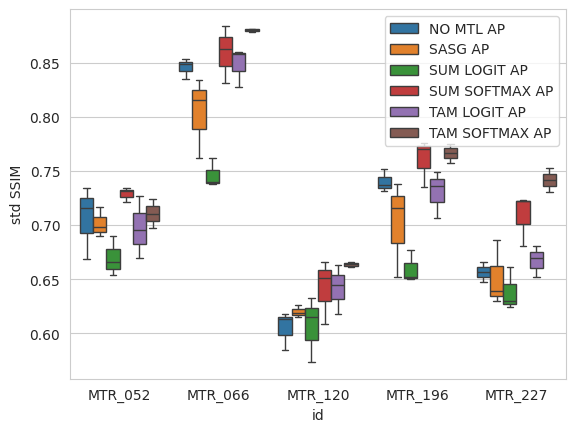

In [110]:
data = dataframe.groupby(['type','echo','id','version'])['SSIM'].agg(['mean']).reset_index()
data =data.loc[np.isin(data['id'], ['MTR_052','MTR_066','MTR_120','MTR_196','MTR_227'])]
data =data.loc[np.isin(data['echo'], ['2'])]
fig, ax = plt.subplots(1,1)
sns.boxplot(data,x='id',y='mean',hue='type',ax=ax)
ax.legend()
ax.set_ylabel('std SSIM')

[atommic W 2024-06-02 17:09:09 atommic_logging:336] /scratch/tmpaquaij/Conda/atommic/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
      data_subset = grouped_data.get_group(pd_key)
    
[atommic W 2024-06-02 17:09:09 atommic_logging:336] /scratch/tmpaquaij/Conda/atommic/lib/python3.10/site-packages/seaborn/categorical.py:632: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
      positions = grouped.grouper.result_index.to_numpy(dtype=float)
    
[atommic W 2024-06-02 17:09:09 atommic_logging:336] /scratch/tmpaquaij/Conda/atommic/lib/python3.10/site-packages/seaborn/_base.py:948: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` ins

Text(0, 0.5, 'std SSIM')

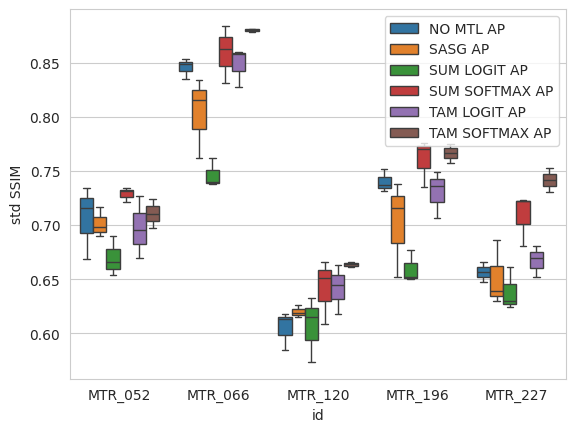

In [111]:
data = dataframe.groupby(['type','echo','id','version'])['SSIM'].agg(['mean']).reset_index()
data =data.loc[np.isin(data['id'], ['MTR_052','MTR_066','MTR_120','MTR_196','MTR_227'])]
data =data.loc[np.isin(data['echo'], ['2'])]
fig, ax = plt.subplots(1,1)
sns.boxplot(data,x='id',y='mean',hue='type',ax=ax)
ax.legend()
ax.set_ylabel('std SSIM')


In [101]:
SSIM = dataframe.groupby(['type','echo','version']).agg(['mean']).reset_index()
SSIM = SSIM.groupby(['type','echo'])['mean'].agg(['mean','std'])
print(SSIM)

SSIM = dataframe.groupby(['type','echo'])['SSIM'].agg(['mean','std']).reset_index()
print(SSIM)

TypeError: agg function failed [how->mean,dtype->object]

In [112]:
SSIM = dataframe.groupby(['type','echo','version'])['SSIM'].agg(['mean']) #determine mean score over all the test subjects
SSIM = SSIM.groupby(['type','echo'])['mean'].agg(['mean','std']).round(3)
SSIM = pd.DataFrame(SSIM['mean'].astype(str) + u"\u00B1" + SSIM['std'].astype(str),columns=['SSIM'])

PSNR = dataframe.groupby(['type','echo','version'])['PSNR'].agg(['mean',])
PSNR = PSNR.groupby(['type','echo'])['mean'].agg(['mean','std']).round(3)
PSNR = pd.DataFrame(PSNR['mean'].astype(str) + u"\u00B1" + PSNR['std'].astype(str),columns=['PSNR'])

HAARPSI = dataframe.groupby(['type','echo','version'])['HaarPSI'].agg(['mean'])
HAARPSI = HAARPSI.groupby(['type','echo'])['mean'].agg(['mean','std']).round(3)
HAARPSI = pd.DataFrame(HAARPSI['mean'].astype(str) + u"\u00B1" + HAARPSI['std'].astype(str),columns=['HAARPSI'])

VSI = dataframe.groupby(['type','echo','version'])['VSI'].agg(['mean'])
VSI = VSI.groupby(['type','echo'])['mean'].agg(['mean','std']).round(3)
VSI = pd.DataFrame(VSI['mean'].astype(str) + u"\u00B1"+ VSI['std'].astype(str),columns=['VSI'])

DICE = dataframe.groupby(['type','version'])['DICE'].agg(['mean'])
print(DICE)
DICE = DICE.groupby(['type'])['mean'].agg(['mean','std']).round(3)
DICE = pd.DataFrame(DICE['mean'].astype(str) + u"\u00B1"+ DICE['std'].astype(str),columns=['DICE'])

F1 = dataframe.groupby(['type','version'])['F1'].agg(['mean','std']).round(3)
F1 = F1.groupby(['type'])['mean'].agg(['mean','std']).round(3)
F1 = pd.DataFrame(F1['mean'].astype(str) + u"\u00B1"+ F1['std'].astype(str),columns=['F1'])

HD95 = dataframe.groupby(['type','version'])['HD95'].agg(['mean','std']).round(3)
HD95 = HD95.groupby(['type'])['mean'].agg(['mean','std']).round(3)
HD95= pd.DataFrame(HD95['mean'].astype(str) + u"\u00B1"+ HD95['std'].astype(str),columns=['HD95'])

IOU = dataframe.groupby(['type','version'])['IOU'].agg(['mean'])
IOU = IOU.groupby(['type'])['mean'].agg(['mean','std']).round(3)
IOU = pd.DataFrame(IOU['mean'].astype(str) + u"\u00B1"+ IOU['std'].astype(str),columns=['IOU'])

ASSD = dataframe.groupby(['type','version'])['ASD'].agg(['mean'])
ASSD = ASSD.groupby(['type'])['mean'].agg(['mean','std']).round(3)
ASSD = pd.DataFrame(ASSD['mean'].astype(str) + u"\u00B1"+ ASSD['std'].astype(str),columns=['ASSD'])

PC = dataframe.groupby(['type','version'])['pc'].agg(['mean'])
PC = PC.groupby(['type'])['mean'].agg(['mean','std']).round(3)
PC = pd.DataFrame(PC['mean'].astype(str) + u"\u00B1"+ PC['std'].astype(str),columns=['PATELLAR T2 E'])

MEN = dataframe.groupby(['type','version'])['men'].agg(['mean'])
MEN = MEN.groupby(['type'])['mean'].agg(['mean','std']).round(3)
MEN = pd.DataFrame(MEN['mean'].astype(str) + u"\u00B1"+ MEN['std'].astype(str),columns=['MENISCUS T2 E'])

TC = dataframe.groupby(['type','version'])['tc'].agg(['mean'])
TC = TC.groupby(['type'])['mean'].agg(['mean','std']).round(3)
TC = pd.DataFrame(TC['mean'].astype(str) + u"\u00B1"+ TC['std'].astype(str),columns=['TIBIAL T2 E'])

FC = dataframe.groupby(['type','version'])['fc'].agg(['mean'])
FC = FC.groupby(['type'])['mean'].agg(['mean','std']).round(3)
FC = pd.DataFrame(FC['mean'].astype(str) + u"\u00B1"+ FC['std'].astype(str),columns=['FIBIAL T2 E'])




dataframe_rec =pd.concat([SSIM,PSNR,HAARPSI,VSI],axis=1)
dataframe_seg =pd.concat([DICE,IOU,F1,HD95,ASSD],axis=1)
dataframe_T2 =pd.concat([MEN,TC,PC,FC],axis=1)
print(DICE)
with pd.ExcelWriter("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/results_table_deep_std.xlsx") as writer:
    dataframe_rec.to_excel(writer,sheet_name='Reconstruction')
    dataframe_seg.to_excel(writer,sheet_name='Segmentation')
    dataframe_T2.to_excel(writer,sheet_name='T2 Quantification')

                            mean
type           version          
NO MTL AP      1        0.751783
               2        0.810794
               3        0.786590
SASG AP         1       0.809509
               1             NaN
               2        0.782868
               3        0.773899
SUM LOGIT AP   1        0.731416
               2        0.747916
               3        0.733089
SUM SOFTMAX AP  1       0.784280
               1             NaN
               2        0.747916
               3        0.733089
TAM LOGIT AP    1       0.783705
               1             NaN
               2        0.777104
               3        0.757121
TAM SOFTMAX AP  1       0.741975
               1             NaN
               2        0.802751
               3        0.780973
                       DICE
type                       
NO MTL AP        0.783±0.03
SASG AP         0.789±0.019
SUM LOGIT AP    0.737±0.009
SUM SOFTMAX AP  0.755±0.026
TAM LOGIT AP    0.773±0.014
TAM SOFTMAX 

In [113]:
SSIM = dataframe.groupby(['type','echo','id'])['SSIM'].agg(['mean']) #determine mean score over all the test subjects
SSIM = SSIM.groupby(['type','echo'])['mean'].agg(['mean','std']).round(3)
SSIM = pd.DataFrame(SSIM['mean'].astype(str) + u"\u00B1" + SSIM['std'].astype(str),columns=['SSIM'])

PSNR = dataframe.groupby(['type','echo','id'])['PSNR'].agg(['mean',])
PSNR = PSNR.groupby(['type','echo'])['mean'].agg(['mean','std']).round(3)
PSNR = pd.DataFrame(PSNR['mean'].astype(str) + u"\u00B1" + PSNR['std'].astype(str),columns=['PSNR'])

HAARPSI = dataframe.groupby(['type','echo','id'])['HaarPSI'].agg(['mean'])
HAARPSI = HAARPSI.groupby(['type','echo'])['mean'].agg(['mean','std']).round(3)
HAARPSI = pd.DataFrame(HAARPSI['mean'].astype(str) + u"\u00B1" + HAARPSI['std'].astype(str),columns=['HAARPSI'])

VSI = dataframe.groupby(['type','echo','id'])['VSI'].agg(['mean'])
VSI = VSI.groupby(['type','echo'])['mean'].agg(['mean','std']).round(3)
VSI = pd.DataFrame(VSI['mean'].astype(str) + u"\u00B1"+ VSI['std'].astype(str),columns=['VSI'])

DICE = dataframe.groupby(['type','id'])['DICE'].agg(['mean'])
DICE = DICE.groupby(['type'])['mean'].agg(['mean','std']).round(3)
DICE = pd.DataFrame(DICE['mean'].astype(str) + u"\u00B1"+ DICE['std'].astype(str),columns=['DICE'])

F1 = dataframe.groupby(['type','id'])['F1'].agg(['mean','std']).round(3)
F1 = F1.groupby(['type'])['mean'].agg(['mean','std']).round(3)
F1 = pd.DataFrame(F1['mean'].astype(str) + u"\u00B1"+ F1['std'].astype(str),columns=['F1'])

HD95 = dataframe.groupby(['type','id'])['HD95'].agg(['mean','std']).round(3)
HD95 = HD95.groupby(['type'])['mean'].agg(['mean','std']).round(3)
HD95= pd.DataFrame(HD95['mean'].astype(str) + u"\u00B1"+ HD95['std'].astype(str),columns=['HD95'])

IOU = dataframe.groupby(['type','id'])['IOU'].agg(['mean'])
IOU = IOU.groupby(['type'])['mean'].agg(['mean','std']).round(3)
IOU = pd.DataFrame(IOU['mean'].astype(str) + u"\u00B1"+ IOU['std'].astype(str),columns=['IOU'])

ASSD = dataframe.groupby(['type','id'])['ASD'].agg(['mean'])
ASSD = ASSD.groupby(['type'])['mean'].agg(['mean','std']).round(3)
ASSD = pd.DataFrame(ASSD['mean'].astype(str) + u"\u00B1"+ ASSD['std'].astype(str),columns=['ASSD'])

PC = dataframe.groupby(['type','id'])['pc'].agg(['mean'])
PC = PC.groupby(['type'])['mean'].agg(['mean','std']).round(3)
PC = pd.DataFrame(PC['mean'].astype(str) + u"\u00B1"+ PC['std'].astype(str),columns=['PATELLAR T2 E'])

MEN = dataframe.groupby(['type','id'])['men'].agg(['mean'])
MEN = MEN.groupby(['type'])['mean'].agg(['mean','std']).round(3)
MEN = pd.DataFrame(MEN['mean'].astype(str) + u"\u00B1"+ MEN['std'].astype(str),columns=['MENISCUS T2 E'])

TC = dataframe.groupby(['type','id'])['tc'].agg(['mean'])
TC = TC.groupby(['type'])['mean'].agg(['mean','std']).round(3)
TC = pd.DataFrame(TC['mean'].astype(str) + u"\u00B1"+ TC['std'].astype(str),columns=['TIBIAL T2 E'])

FC = dataframe.groupby(['type','id'])['fc'].agg(['mean'])
FC = FC.groupby(['type'])['mean'].agg(['mean','std']).round(3)
FC = pd.DataFrame(FC['mean'].astype(str) + u"\u00B1"+ FC['std'].astype(str),columns=['FIBIAL T2 E'])




dataframe_rec =pd.concat([SSIM,PSNR,HAARPSI,VSI],axis=1)
dataframe_seg =pd.concat([DICE,IOU,F1,HD95,ASSD],axis=1)
dataframe_T2 =pd.concat([MEN,TC,PC,FC],axis=1)

with pd.ExcelWriter("/data/projects/utwente/recon/SKM-TEA/v1-release/predictions/MTLRS_SENSE/predictions_8x/results_table_std_patient.xlsx") as writer:
    dataframe_rec.to_excel(writer,sheet_name='Reconstruction')
    dataframe_seg.to_excel(writer,sheet_name='Segmentation')
    dataframe_T2.to_excel(writer,sheet_name='T2 Quantification')

<KeysViewHDF5 ['intermediate_loglike', 'intermediate_reconstruction', 'reconstruction', 'segmentation', 'target_reconstruction', 'target_segmentation', 'zero_filled']>


In [43]:
fig, ax = plt.subplots((4,8))


(80, 5, 5, 256, 256)


In [48]:
import torch
from atommic.collections.segmentation.losses.dice import one_hot
%matplotlib inline

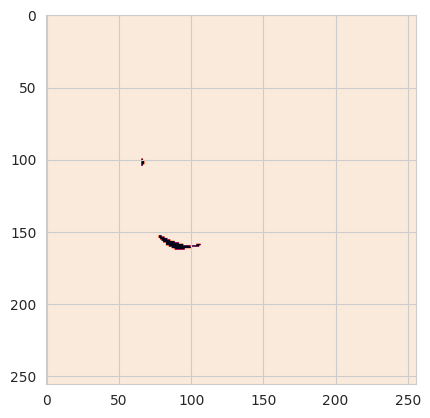

In [59]:
predictions=prediction_mtlrs_1[:,-1,:]
predictions = torch.softmax(torch.from_numpy(predictions), dim=1)
predictions = one_hot(torch.argmax(torch.abs(predictions), dim=1, keepdim=True),
                                     num_classes=predictions.shape[1]).float().numpy()
plt.imshow(predictions[40,0,:,:])
plt.show()